# Log Normal Price Simulation

The Black–Scholes–Merton option pricing model is based on the price of the underlying evolving in time as a [Geometric Brownian motion](https://en.wikipedia.org/wiki/Geometric_Brownian_motion):

```
S(T) = S(0) * exp[(r - 0.5 * σ^2)*T + σ√Tz]

where
S(T) is the price of the underlying at the end of the time interval
S(0) is the price of the underlying at the start of the time interval
T is the length of the time interval
r is the risk-free rate
σ is the volatility
z is a standard normally distributed random variable
```

Black–Scholes–Merton have resolved the stochastic differential equations into an analytical formula, but it can also be resolved numerically in a discrete context.

In [134]:

import math

import pandas as pd
# import pandas.io.sql as sqlio

import numpy as np
from numpy.random import default_rng
np.set_printoptions(precision=5, suppress=True)

import matplotlib as mpl
import matplotlib.pyplot as plt

import scipy as scipy

import psycopg2

# import seaborn as sns

from math import log, sqrt, exp, pi
from scipy.stats import norm, laplace, t as student_t

# Markdown in code cell
from IPython.display import Markdown as md


plt.style.use('seaborn')
plt.colormaps
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.family'] = 'serif'

# btcusd_1min = pd.read_csv("./BTCUSD.csv", sep=",", header=0, names=["date","open","high","low","close"], index_col="date")

# btcusd_1min['ret_2min'] = np.log(btcusd_1min['close'] / btcusd_1min['close'].shift(2))

# vol_2min = btcusd_1min['ret_2min'].std()

# # number of 2-minute per year
# nb_2min_per_year = 60/2 * 24 * 365.25
# vol_ann = vol_2min * sqrt(nb_2min_per_year)



## Monte Carlo Simulation

To look at what those future uncertain values of the underlying might look like, one can sample _I_ times (ex.: 1,000,000) the standard normal distribution and calculate _I_ terminal prices. 

This process is called a [Monte Carlo simulation](https://en.wikipedia.org/wiki/Monte_Carlo_method).

The following will be used in the simulation below:

```
S(T) = S(0) * exp[(r - 0.5 * σ^2)*T + σ√Tz]

where
S(0) = 30,000.00 USD
T = 2 minutes, i.e. 3.80e-06 year
r = 0
σ = 150.53% annual volatility
```


In [135]:

# underlying price at t=0
S0 = 30_000.00

# risk free rate (no present value discounting)
r = 0.0

# 2min yearly fraction
T = 1 / (60/2 * 24 * 365.25)

# annualized 2min volatility
sigma = vol_ann

# number of price simulations
I = 1_000_000

# fixes the seed for reproducibility
rng = default_rng(99)
# rng = default_rng()

# underlying price vector at maturity
ST = S0 * np.exp((r - sigma ** 2 / 2) * T + sigma * math.sqrt(T) * rng.standard_normal(I))

# mean of terminal prices
ST_mean = ST.mean()

# standard deviation of terminal prices
ST_std = ST.std()

header = '''|variable|value|
|:-:|-:|'''

table = ""
table += f"|S(0)|{float('%.8g' % S0)} USD|\n"
table += f"|T|{float('%.3g' % T)}|\n"
table += f"|r|{r}|\n"
table += f"|σ|{float('%.5g' % (sigma*100))}%|\n"
table += f"|I|{I}|\n"

table2 = ""
table2 += f"|S(T)|{ST[:5].round(1)}...|\n"

table3 = ""
table3 += f"|S(T) mean|{float('%.7g' % ST_mean)}|\n"
table3 += f"|S(T) std|{float('%.4g' % ST_std)}|\n"

md(f"""### Simulation calculated variables
{header}
{table}
### Terminal prices samples
{header}
{table2}
### Terminal prices stats
{header}
{table3}""")


### Simulation calculated variables
|variable|value|
|:-:|-:|
|S(0)|30000.0 USD|
|T|3.8e-06|
|r|0.0|
|σ|150.53%|
|I|1000000|

### Terminal prices samples
|variable|value|
|:-:|-:|
|S(T)|[30007.1 29959.  30004.3 30060.4 29845.6]...|

### Terminal prices stats
|variable|value|
|:-:|-:|
|S(T) mean|30000.06|
|S(T) std|88.05|


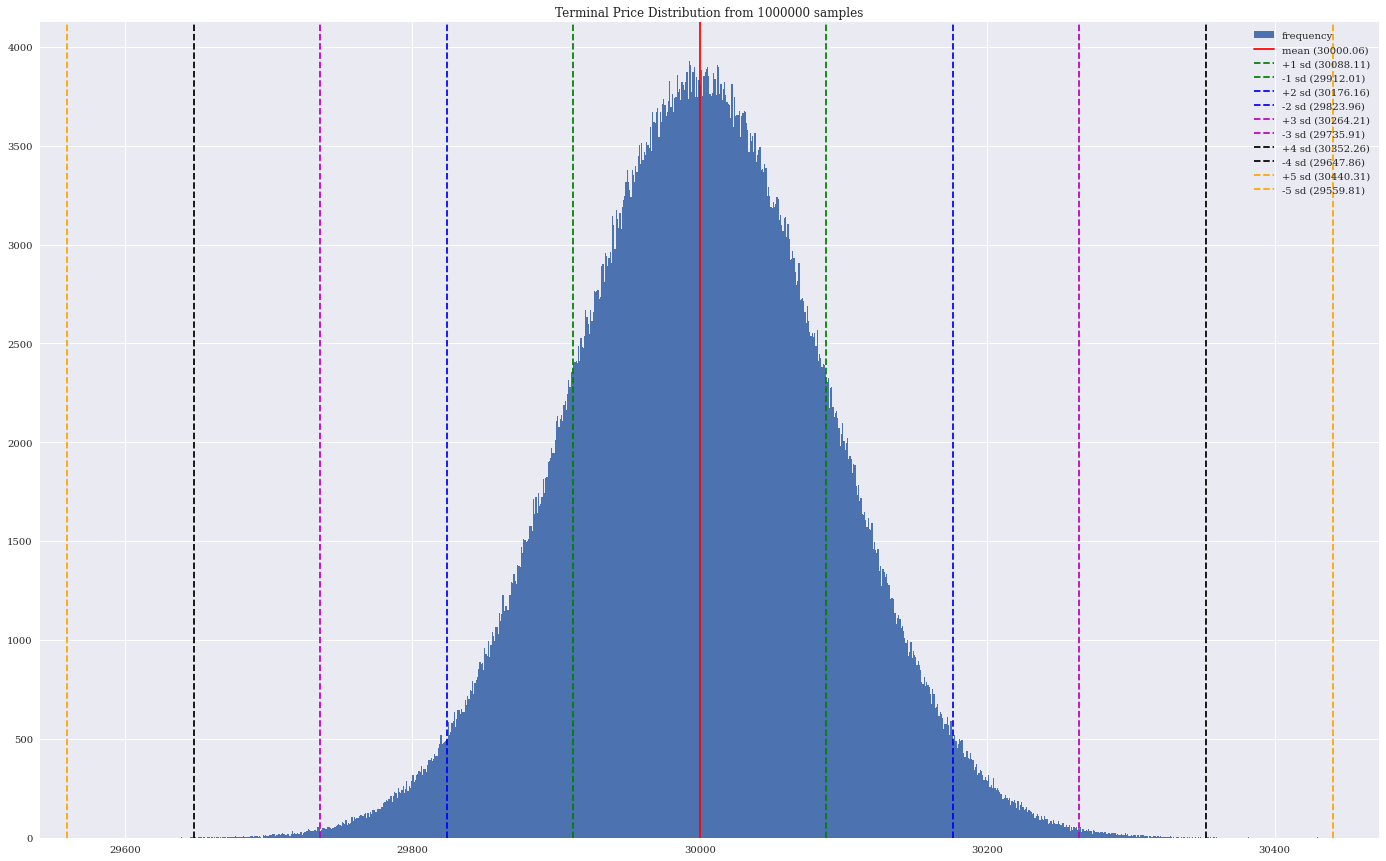

In [136]:

plt.figure(figsize=(24, 15))
plt.hist(ST, bins=1000, label='frequency');

plt.axvline(ST_mean, color='r', label=f"mean ({float('%.7g' % (ST_mean))})")

plt.axvline(ST_mean + 1 * ST_std, color='g',      label=f"+1 sd ({float('%.7g' % (ST_mean + 1 * ST_std))})", linestyle='--')
plt.axvline(ST_mean - 1 * ST_std, color='g',      label=f"-1 sd ({float('%.7g' % (ST_mean - 1 * ST_std))})", linestyle='--')

plt.axvline(ST_mean + 2 * ST_std, color='b',      label=f"+2 sd ({float('%.7g' % (ST_mean + 2 * ST_std))})", linestyle='--')
plt.axvline(ST_mean - 2 * ST_std, color='b',      label=f"-2 sd ({float('%.7g' % (ST_mean - 2 * ST_std))})", linestyle='--')

plt.axvline(ST_mean + 3 * ST_std, color='m',      label=f"+3 sd ({float('%.7g' % (ST_mean + 3 * ST_std))})", linestyle='--')
plt.axvline(ST_mean - 3 * ST_std, color='m',      label=f"-3 sd ({float('%.7g' % (ST_mean - 3 * ST_std))})", linestyle='--')

plt.axvline(ST_mean + 4 * ST_std, color='k',      label=f"+4 sd ({float('%.7g' % (ST_mean + 4 * ST_std))})", linestyle='--')
plt.axvline(ST_mean - 4 * ST_std, color='k',      label=f"-4 sd ({float('%.7g' % (ST_mean - 4 * ST_std))})", linestyle='--')

plt.axvline(ST_mean + 5 * ST_std, color='orange', label=f"+5 sd ({float('%.7g' % (ST_mean + 5 * ST_std))})", linestyle='--')
plt.axvline(ST_mean - 5 * ST_std, color='orange', label=f"-5 sd ({float('%.7g' % (ST_mean - 5 * ST_std))})", linestyle='--')

plt.title(f'Terminal Price Distribution from {I} samples')
plt.legend(loc='best');
plt.show()

## Option payoff

Looking at a call option, the payoff at maturity (t=T) is define as:

```
C(T) = max[S(T) - K, 0]

where 
K is the strike / exercise price
```

So given a price at maturity greater than the strike price, the option would be exercised. 

Its payoff would be the value of the underlying received (S(T)) less the amount paid for it (K). 

Else the option would yield a loss and so is assumed to not be exercised and the payoff is zero.

Therefore the value of the option at time t=0 is the discounted expected (average) payoff from time t=T, given that all _I_ scenarios are equally likely as no arbitrage is allowed.


In [137]:

# at-the-money strike price => fair value @ 50%-50% exercise probability
K = S0

# call option payoff at maturity
CT = np.maximum(ST - K, 0)

CT_mean = CT.mean()
CT_std = CT.std()

# call option fair value
C0 = math.exp(-r * T) * CT_mean

header = '''|variable|value|
|:-:|-:|'''

table = ""
table += f"|K|{float('%.8g' % S0)} USD|\n"

table2 = ""
table2 += f"|C(T)|{CT[:5].round(1)}...|\n"

table3 = ""
table3 += f"|C(T) mean|{float('%.4g' % CT_mean)}|\n"
table3 += f"|C(T) std|{float('%.4g' % CT_std)}|\n"
table3 += f"|C0|{float('%.4g' % C0)}|\n"

md(f"""### Option payoff variables
{header}
{table}
### Terminal option payoff samples
{header}
{table2}
### Terminal option payoff stats
{header}
{table3}""")



### Option payoff variables
|variable|value|
|:-:|-:|
|K|30000.0 USD|

### Terminal option payoff samples
|variable|value|
|:-:|-:|
|C(T)|[ 7.1  0.   4.3 60.4  0. ]...|

### Terminal option payoff stats
|variable|value|
|:-:|-:|
|C(T) mean|35.16|
|C(T) std|51.52|
|C0|35.16|


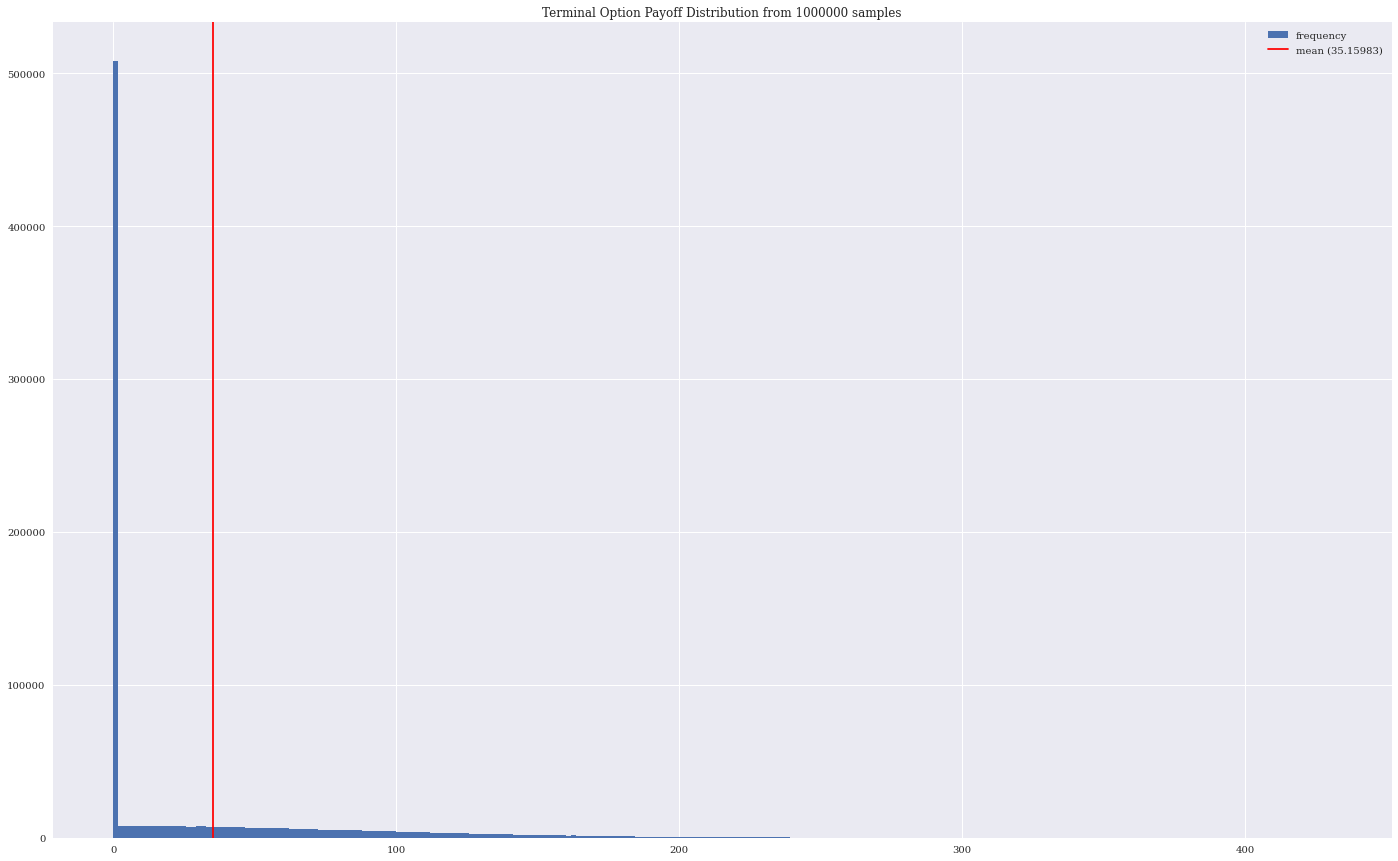

In [138]:

plt.figure(figsize=(24, 15))
plt.hist(CT, bins=250, label='frequency');

plt.axvline(CT_mean, color='r', label=f"mean ({float('%.7g' % (CT_mean))})")

plt.title(f'Terminal Option Payoff Distribution from {I} samples')
plt.legend(loc='best');
plt.show()

## Present Value of the expected payoff

Given that, in this case, the time interval (maturity) is 2 minutes, there's no interest to be gained by investing a certain amount temporarily in a risk-free asset (bank account, short-rate bond, etc.) so the risk-free rate is zero and the discounted / present value is the same as the terminal / future value.

```
C0 = Expected Value / Average / Mean of [C(T)]

```



## Black–Scholes–Merton option price

The BSM call option price formula is:
```
C(0) = S(0) * N(d1) - K * exp[-r * T] * N(d2)

with
d1 = (ln[S(0) / K] + (r + 0.5 * σ^2)*T) / σ√T
d2 = d1 - σ√T

and where
N() is the standard normal cummulative probability distribution function
N(d2) can be interpreted as the probability that a call option will be exercised
N(d1) is not easy to interpret by itself
S(0)*N(d1)*exp[rT] can be interpreted as the expected terminal underlying price when underlying prices less than the strike are counted as zero (to present value is then: S(0)*N(d1))
```

So the call option price is the discounted expected value of the terminal underlying price (with below strike prices accounted as zero) less the the strike price given exercise (weighted by the probability of exercise).




In [139]:

# theoretical non-simulated call price
d1 = (log(S0/K) + (r + 0.5 * sigma**2) * T) / sigma / sqrt(T)
d2 = d1 - sigma * sqrt(T)
N_d1 = norm.cdf(d1)
N_d2 = norm.cdf(d2)
BSM_C0 = S0 * N_d1 - K * exp(-r*T) * N_d2

header = '''|variable|value|
|:-:|-:|'''

table = ""
table += f"|BSM C0|{float('%.4g' % BSM_C0)} USD|\n"
table += f"|MC C0|{float('%.4g' % C0)} USD|\n"

table2 = ""
table2 += f"|d1|{float('%.6g' % (d1))}|\n"
table2 += f"|d2|{float('%.6g' % (d2))}|\n"
table2 += f"|N(d1)|{float('%.4g' % (N_d1))}|\n"
table2 += f"|N(d2)|{float('%.4g' % (N_d2))}|\n"
table2 += f"|S(0)*N(d1)|{float('%.7g' % (S0*N_d1))} USD|\n"
table2 += f"|-K*N(d2)|{float('%.7g' % (-K*N_d2))} USD|\n"

md(f"""### Option price comparison
{header}
{table}
### BSM Terms
{header}
{table2}""")


### Option price comparison
|variable|value|
|:-:|-:|
|BSM C0|35.13 USD|
|MC C0|35.16 USD|

### BSM Terms
|variable|value|
|:-:|-:|
|d1|0.00146768|
|d2|-0.00146768|
|N(d1)|0.5006|
|N(d2)|0.4994|
|S(0)*N(d1)|15017.57 USD|
|-K*N(d2)|-14982.43 USD|


## Identifying BSM terms in terminal price distribution



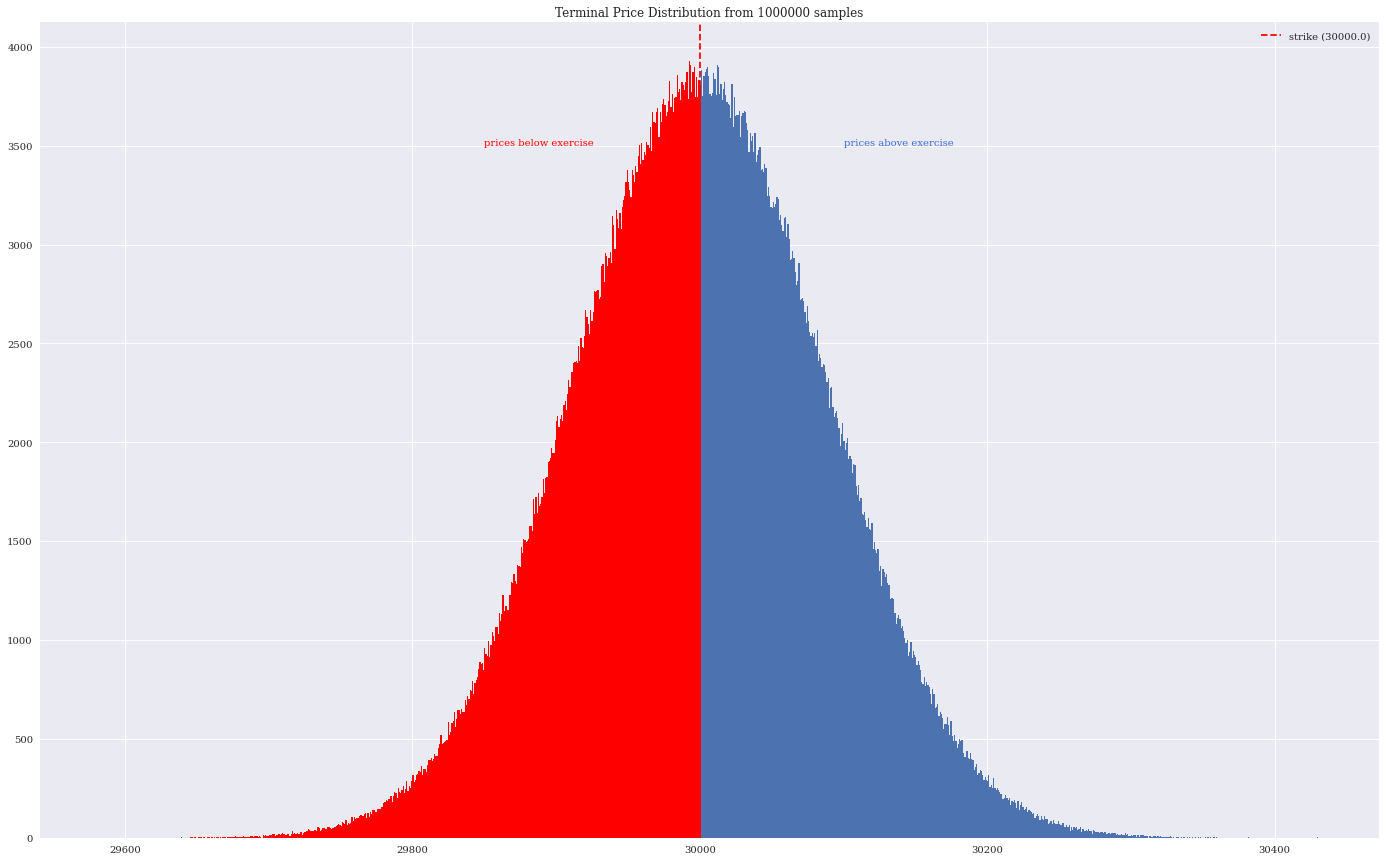

In [140]:

plt.figure(figsize=(24, 15))
n, bins, patches = plt.hist(ST, bins=1000);
for c, p in zip(bins, patches):
    if c <= K:
        plt.setp(p, 'facecolor', 'red')
    # else:
    #     plt.setp(p, 'facecolor', 'royalblue')

plt.axvline(K, color='r', label=f"strike ({float('%.7g' % (K))})", linestyle='--')

plt.text(29850, 3500, "prices below exercise", color='r')
plt.text(30100, 3500, "prices above exercise", color='royalblue')

plt.title(f'Terminal Price Distribution from {I} samples')
plt.legend(loc='best');
plt.show()


In [141]:

ST_below_K = ST[ST <= K]
ST_above_K = ST[ST > K]

ST_N_d1 = np.concatenate((ST_below_K*0, ST_above_K))


header = '''|variable|value|
|:-:|-:|'''

table = ""
table += f"|Count(ST <= K)|{ST_below_K.size}|\n"
table += f"|Count(ST  > K)|{ST_above_K.size}|\n"
table += f"|Total Count|{ST_below_K.size + ST_above_K.size}|\n"
table += f"|Nbr of sims (I)|{I}|\n"
table += f"|Percent(ST <= K)|{float('%.4g' % (ST_below_K.size/I))}|\n"
table += f"|Percent(ST  > K)|{float('%.4g' % (ST_above_K.size/I))}|\n"

table2 = ""
table2 += f"|S(T)*N(d1)|{float('%.7g' % (ST_N_d1.mean()))} USD|\n"
table2 += f"|-K*N(d2)|{float('%.7g' % (-K*(ST_above_K.size/I)))} USD|\n"
table2 += f"|S(T)\*N(d1) - K\*N(d2)|{float('%.4g' % (ST_N_d1.mean()-K*(ST_above_K.size/I)))} USD|\n"

md(f"""### Frequency stats
{header}
{table}
### BSM Terms from terminal prices
{header}
{table2}
""")


### Frequency stats
|variable|value|
|:-:|-:|
|Count(ST <= K)|500166|
|Count(ST  > K)|499834|
|Total Count|1000000|
|Nbr of sims (I)|1000000|
|Percent(ST <= K)|0.5002|
|Percent(ST  > K)|0.4998|

### BSM Terms from terminal prices
|variable|value|
|:-:|-:|
|S(T)*N(d1)|15030.18 USD|
|-K*N(d2)|-14995.02 USD|
|S(T)\*N(d1) - K\*N(d2)|35.16 USD|



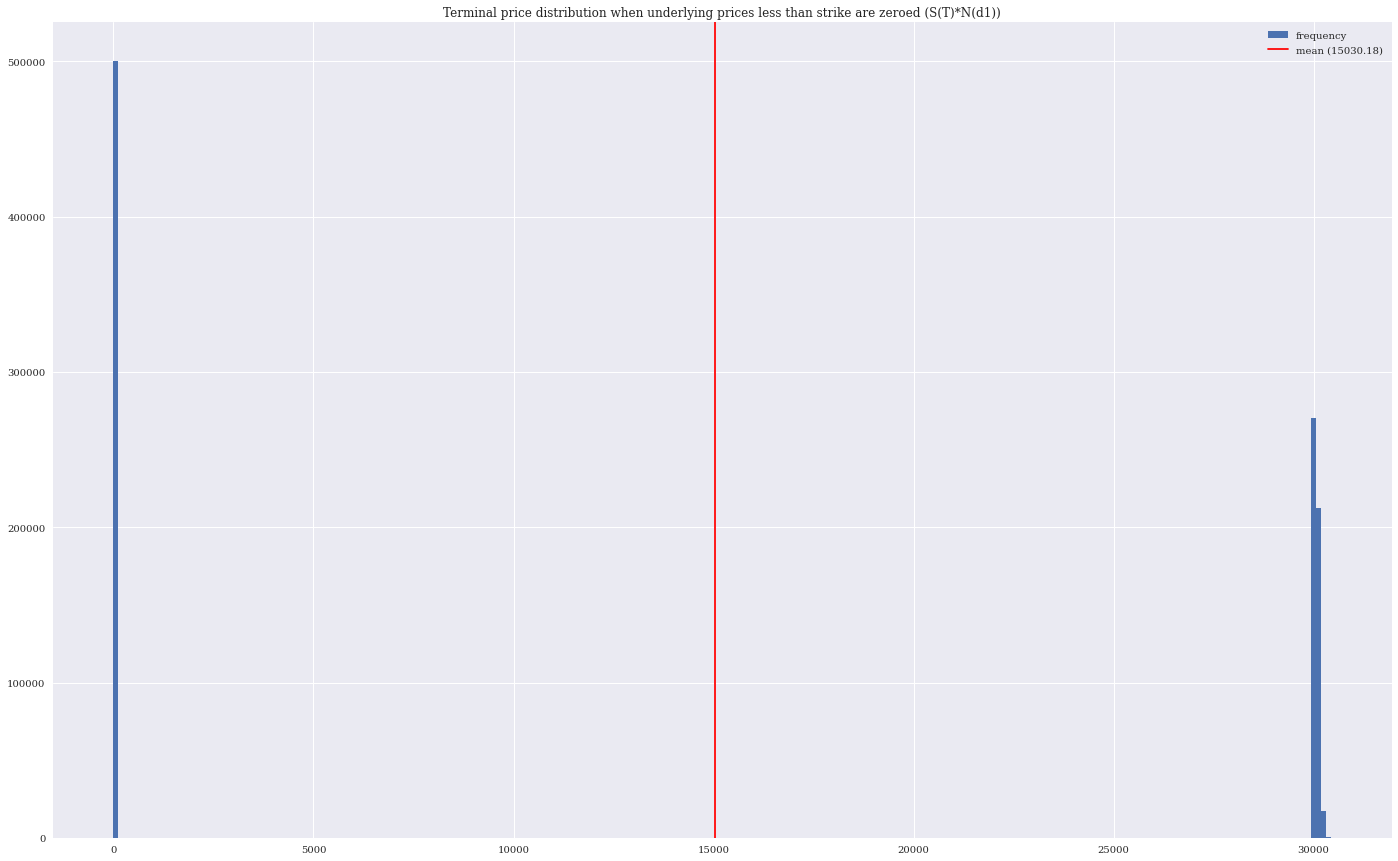

In [142]:

plt.figure(figsize=(24, 15))
plt.hist(ST_N_d1, bins=250, label='frequency');

plt.axvline(ST_N_d1.mean(), color='r', label=f"mean ({float('%.7g' % (ST_N_d1.mean()))})")

plt.title(f'Terminal price distribution when underlying prices less than strike are zeroed (S(T)*N(d1))')
plt.legend(loc='best');
plt.show()

## At-the-money call option pricing summary

It has been established that using the same assumptions as the BSM, it is possible to calculate the option price numerically using the Monte Carlo method, and confirmed by the BSM formula, plus the BSM terms from the formula can be identified in the simulation data set, extracted and used as a third way to calculate the call option price.

A strike price equal to the initial (t=0) underlying price was used so far and is called "at-the-money" since it has no instant gains nor losses if exercised.

In comparison an "in-the-money" call option has K < S0 and has an instant gain of S0 - K.

And vice-versa for an "out-of-the-money" call option with K > S0.

The next section will go over the same analyis for an "out-of-the-money" call option as the basis of an eventual fee structure for a 2-minute maturity no premium ("free") option given by:

```
K_free_option = S0 * (1 + fee%)
```